# project notebook

## table of contents:

###  [1. collect reddit data ](#section_1)

###  [2. collect stock price data](#section_2)

### [3. analyze](#section_3)

### [4. predict](#section_4)

### [5. conclusion](#section_5)

<a id='section_1'></a>

# 1. collect reddit data

## 1.1 get credentials

In [14]:
import yaml

global client_id
global secret
global developers
global password

with open("config.yml", 'r') as configfile:
    cfg = yaml.load(configfile)

client_id = cfg['reddit_credentials']['client_id']
secret = cfg['reddit_credentials']['secret']
developers = cfg['reddit_credentials']['developers']
password = cfg['reddit_credentials']['password']

## 1.2 fetch data from reddit

### create connection and test

In [20]:
import praw

reddit = praw.Reddit(client_id=client_id,
                     client_secret= secret, password=password,
                     user_agent='agent', username=developers)

In [99]:
subreddit = reddit.subreddit('technology')

hot_subs = subreddit.hot(limit = 3)

for submission in hot_subs:
    print(submission.title)

Any form of threatening, harassing, or violence / physical harm towards anyone will result in a ban
Got a tech question or want to discuss tech? Weekly /r/Technology Tech Support / General Discussion Thread
#NetNeutrality: Supreme Court Hands Over a Major Victory for Open Internet Advocates


In [101]:
submission = reddit.submission(id='9jdami')

In [32]:
for top_level_comment in submission.comments:
    print(top_level_comment.body)

Pretty soon they are gonna need to start storing unsold graphics cards inside of Fort Knox based on their pricing rise.
Would this impact existing products? I was considering picking up a 1080ti after the 2080ti has been down for a while but don't want it to cost more than it does now.
The reason why the 2080ti is  priced at 1000 finally made clear.
We live in a society.
Or they can always make it in a non-tariff country.
Nah they just need to engage contract manufacturers in Taiwan or elsewhere.  Or ship parts from China and assemble in Malaysia, or..... so many other ways to get around the tarriff. 
As the prices of all consumer goods rise, retailers need to start putting big bold stickers on products that cost way more "Price increase due to Donald Trump's trade tariffs."
God damn it, I need an upgrade for my graphics card. Sucks using a 960 still :c
Imma get that geforce graphics card before the end of this year!
They should just "bundle" the cards in cheap towers or cases. 
Would 

### util functions

In [204]:
def get_sub_comments(comment, allComments, verbose=True):
    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
        if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)
    


def get_all_comments(r, submissionId, verbose=True):
    # r is reddit client
    submission = r.submission(submissionId)
    comments = submission.comments
    commentsList = []
    for comment in comments:
        if not isinstance(comment, praw.models.MoreComments):
            get_sub_comments(comment, commentsList, verbose=verbose)
    return commentsList


In [214]:
from datetime import datetime, timedelta

def utc_to_datetime(sec):
    utc_date = datetime(1970, 1, 1, 0, 0, 0)
    date =  utc_date+ timedelta(seconds=sec)
    return date

In [136]:
def submission_to_json(sub):
    json = {}
    json['_id'] = sub.id
    json['title'] = sub.title
    json['author'] = str(sub.author)
    json['date'] = utc_to_datetime(sub.created_utc)
    json['num_comments'] = sub.num_comments
    json['permalink']= sub.permalink
    json['score'] = sub.score
    json['stickied'] = sub.stickied
    json['upvote_ratio'] = sub.upvote_ratio
    return json


def comment_to_json(comment):
    json = {}
    json['_id'] = comment.id
    try:
        json['author'] = str(comment.author)
    except:
        print comment.id
        pass
    json['date'] = utc_to_datetime(comment.created_utc)
    json['body'] = comment.body
    json['link_id'] = comment.link_id
    json['parent_id'] = comment.parent_id
    json['score'] = comment.score
    return json
    

def write_to_mongo(json, collection):
    try:
        collection.insert_one(json)
    except pymongo.errors.DuplicateKeyError:
        _id = json['_id']
        collection.update_one({ "_id": _id }, {'$set': json})
    except Exception as e:
        print e
        
        

## 1.3 setup mongo

In [137]:
import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING
from pymongo import MongoClient

mongo = MongoClient('localhost', 27017)
amd_db = mongo['amd']
amd_sub = amd_db['submissions']
amd_com = amd_db['comments']


# create index in mongodb - date, submission id
date_index = IndexModel([('date', DESCENDING)])
subid_index = IndexModel([('parent_id', ASCENDING)])
amd_com.create_indexes([date_index, subid_index])
amd_sub.create_indexes([date_index])

[u'date_-1']

## 1.4 fetch and write

In [213]:
subreddit = reddit.subreddit('technology')

amd_submissions = subreddit.search("AMD", limit=None)

for submission in amd_submissions:
    sub_json = submission_to_json(submission)
    write_to_mongo(sub_json, amd_sub)
    print 'processed submission: ', submission.id
    # get all comments and filter out ones that are not comments
    comments = filter(lambda elm: isinstance(elm, praw.models.Comment), get_all_comments(reddit, submission.id))
    for comment in comments:
        com_json = comment_to_json(comment)
        write_to_mongo(com_json, amd_com)
    

processed submission:  9jdami
processed submission:  9usl4f
processed submission:  9g42q1
processed submission:  9ur3xe
processed submission:  9tp7k7
processed submission:  9qdhd4
processed submission:  9szhd9
processed submission:  9mnojq
processed submission:  952i1m
processed submission:  9gnopn
processed submission:  9f4opc
processed submission:  9rihsv
processed submission:  9avy1j
processed submission:  9myk3o
processed submission:  9a0pn5
processed submission:  8srt54
processed submission:  936p6w
processed submission:  9miqjk
processed submission:  8x96ua
processed submission:  8ttqo4
fetching (57 comments fetched total)
processed submission:  7nzpqb
fetching (11 comments fetched total)
fetching (20 comments fetched total)
fetching (22 comments fetched total)
fetching (24 comments fetched total)
fetching (27 comments fetched total)
fetching (29 comments fetched total)
fetching (35 comments fetched total)
fetching (44 comments fetched total)
fetching (52 comments fetched total)


<a id='section_2'></a>

# 2. collect stock price data

## 2.1 fetch data from api

In [231]:
import pyEX

amd_stock = pyEX.chartDF('AMD', timeframe='1y')
# amd_stock.to_csv('amd_stock_prices.csv', sep=',')

In [398]:
amd_stock.to_pickle("amd_stock.pkl")

<a id='section_3'></a>

# 3. analyze

## 3.1 compute polarity

In [641]:
import pandas as pd
from textblob import TextBlob

def get_stock_price(picklename, start_date, end_date):
    # outputs df with date and close price
    # ex. start_date ='2018-11-05'= end_date, returns stock price for 2018-11-05
    df = pd.read_pickle(picklename)
    #df.index = pd.to_datetime(df.index)
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]['close']
    return df
    
    
def get_comments_by_date(col, start_date, end_date):
    # col is the collection, ex. amd_com
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_comm = {}
    date_score = {} # total score by date
    
    for doc in col.find({'date': {'$gte': start, '$lte': end}},{'body':1, 'date':1, 'score':1, '_id':0}):
        date = doc['date'].date()
        if date in date_comm:
            date_comm[date] += doc['body']
            date_score[date] += doc['score']
        else:
            date_comm[date] = doc['body']
            date_score[date] = doc['score']
    return date_comm, date_score


def get_submissions_by_date(col, start_date, end_date):
    # col is the collection, ex. amd_com
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_comm = {}
    date_score = {} # total score by date
    
    for doc in col.find({'date': {'$gte': start, '$lte': end}},{'title':1, 'date':1, 'score':1, '_id':0}):
        date = doc['date'].date()
        if date in date_comm:
            date_comm[date] += doc['title']
            date_score[date] += doc['score']
        else:
            date_comm[date] = doc['title']
            date_score[date] = doc['score']
    return date_comm, date_score


def get_polarity(dic_or_df):
    if isinstance(dic_or_df, dict):
        df = pd.DataFrame.from_dict(dic_or_df, orient='index').rename(columns={0:'text'})
    else:
        df = dic_or_df
    try:
        df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment[0])
    except UnicodeDecodeError:
        df['polarity'] = df['text'].str.decode('utf-8').apply(lambda x: TextBlob(x).sentiment[0])
    return df


def get_scores(dic):
    df = pd.DataFrame.from_dict(dic, orient='index').rename(columns={0:'score'})
    return df


def fill_dates(df, start_date, end_date, fill_value):
    # start date and end date are strings
    idx = pd.date_range(start_date, end_date)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=fill_value)
    return df 

def fill_stock_price(df, start_date, end_date):
    # fill-in weekend prices as the previous friday's price
    idx = pd.date_range(start_date, end_date)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=None)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

In [571]:
amd_comm, amd_score = get_comments_by_date(amd_com, '2018-01-01', '2018-10-27')

amd_comm_df = get_polarity(amd_comm)

amd_comm_df.head(n=3)

,text,polarity
2018-02-13,"I don't read that article, but saw few videos ...",0.32500
2018-05-06,It looks like AMD might just be trying to prot...,0.04375
2018-07-31,Last Card to smack Nvidia was the 7970 which t...,0.31000


## 3.2 plot comment polarity

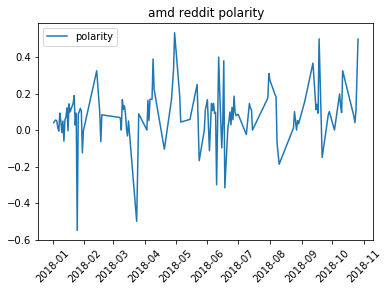

In [407]:
%matplotlib inline

amd_comm_df.plot(y='polarity', use_index=True, title = 'amd reddit polarity', rot = 45)

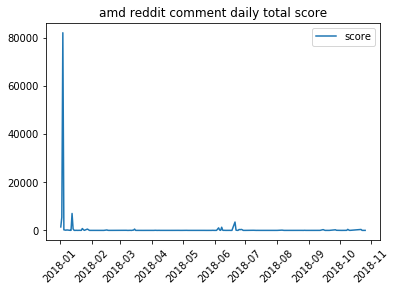

In [419]:
get_scores(amd_score).plot(use_index=True, title = 'amd reddit comment daily total score', rot = 45)

## 3.3 plot stock prices

In [401]:
amd_stock = get_stock_price('amd_stock.pkl', '2018-01-01', '2018-10-27')

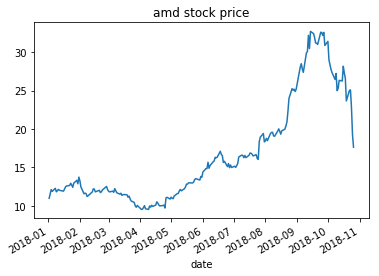

In [487]:
amd_stock.plot(title = 'amd stock price')

In [574]:
amd_comm_df = fill_dates(amd_comm_df,'2018-01-01', '2018-10-27',0 )

## 3.4 comment polarity and stock price

In [645]:
def plot_polarity_price(series1, series2, label1, label2, xlabel, figsize=(12,5)):
    plt.figure(figsize=(12,5))
    plt.xlabel(xlabel)

    ax1 = series1.plot(color='blue', grid=True, label=label1)
    ax2 = series2.plot(color='red', grid=True, secondary_y=True, label=label2)

    ax1.legend(loc=1)
    ax2.legend(loc=2)

    plt.show()

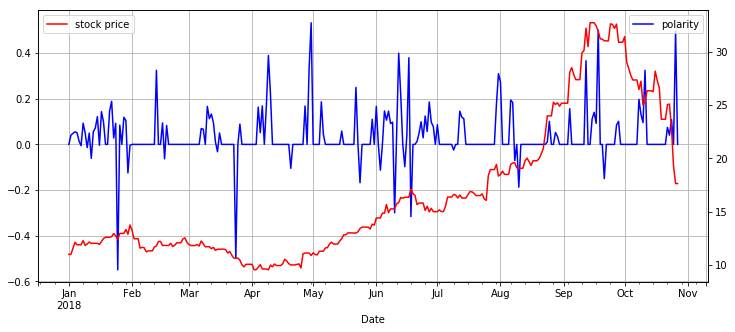

In [649]:
plot_polarity_price(amd_comm_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.5 submission polarity and stock price

In [593]:
amd_submissions, amd_sub_score = get_submissions_by_date(amd_sub, '2018-01-01', '2018-10-27')

amd_sub_df = get_polarity(amd_submissions)

In [594]:
amd_sub_df = fill_dates(amd_sub_df, '2018-01-01', '2018-10-27',0)

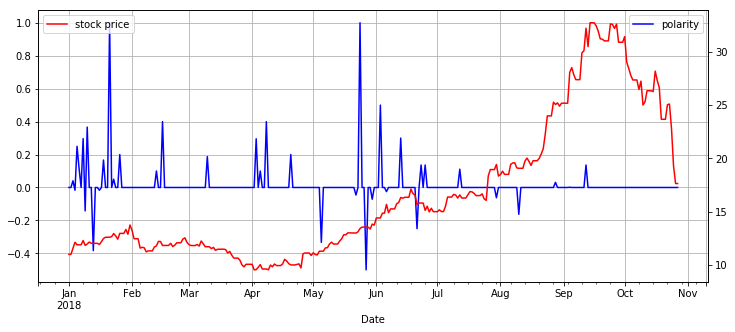

In [648]:
plot_polarity_price(amd_sub_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.6 submission & comments polarity vs. stock price

In [643]:
amd_sub_comm_df = (amd_sub_df['text'].str.encode('utf-8').fillna(value=' ')\
    +amd_comm_df['text'].str.encode('utf-8').fillna(value= ' ')).to_frame()
    
amd_sub_comm_df = get_polarity(amd_sub_comm_df)


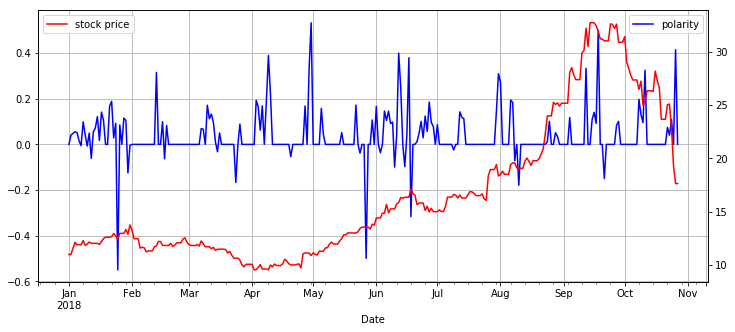

In [647]:
plot_polarity_price(amd_sub_comm_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.7 rolling average

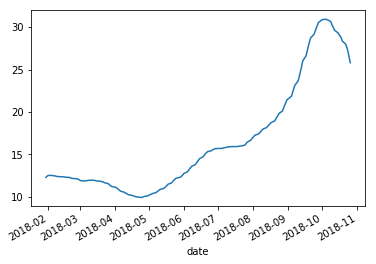

In [486]:
amd_stock.rolling(window=20).mean().plot()

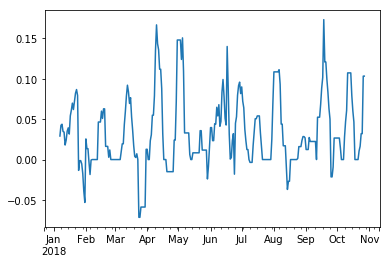

In [496]:
amd_comm_df['polarity'].rolling(window=7).mean().plot()

## 3.8 cross correlation

In [527]:
amd_stock = fill_stock_price(amd_stock, '2018-01-01', '2018-10-27')

In [653]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compute_corr(series1, series2):
    corr = np.correlate(np.asarray(series1),np.asarray(series2),'full')
    plt.plot(corr)

    print 'corr: ', np.argmax(corr)
    print 'days lag: ', np.argmax(corr)-len(series1)

corr:  301
days lag:  1


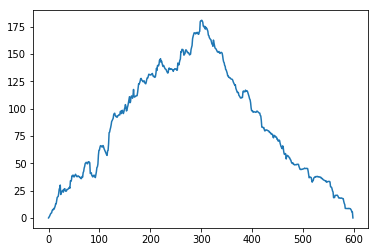

In [655]:
plot_compute_corr(amd_comm_df['polarity'], amd_stock)

corr:  184
days lag:  -116


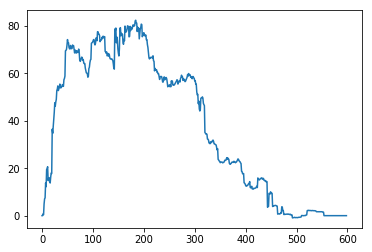

In [656]:
plot_compute_corr(amd_sub_df['polarity'], amd_stock)

corr:  301
days lag:  1


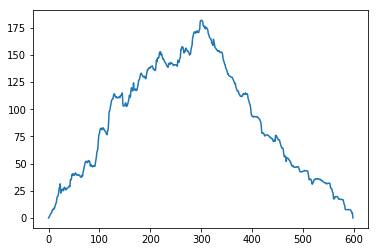

In [657]:
plot_compute_corr(amd_sub_comm_df['polarity'], amd_stock)

<a id='section_4'></a>

# 4. predict

## 4.1 prepare train & testing set

In [693]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#a = np.arange(10)
#print rolling(a, 3)

In [722]:
x_train = rolling(amd_sub_df['polarity'][:168], 7)
y_train = rolling(amd_stock[116:284],7)

x_test = rolling(amd_sub_df['polarity'][168:184], 7)
y_test = rolling(amd_stock[284:],7)

## 4.2 model and predict

In [842]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
  
rgr = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
rgr.fit(x_train, y_train)
y_pred2 = rgr.predict(x_test)

In [770]:
def pad_vec(vec, positions):
    # positions is list of indexes to pad the vector
    for n in positions:
        vec = np.insert(vec, n, 0) 
    return vec

# pad_vec(np.array([1,2,3,4,5]), [0,1,2,8])
# array([0, 0, 0, 1, 2, 3, 4, 5, 0])

In [819]:
def get_avg_ypred(y_pred):
    
    arr_len = len(y_pred[0])
    arr_wid = y_pred.shape[0]
    
    final_len = arr_len+arr_wid -1
    final = np.zeros(final_len,)

    leading_zeros = 0
    ending_zeros = arr_wid-1

    count_values = np.zeros(final_len,)
    
    result = []
    
    def f(n):
        return 1 if n>0 else 0

    for vec in y_pred:

        pos = list(range(0,leading_zeros))+list(range(arr_len+leading_zeros,final_len))
        vec = pad_vec(vec, pos)
        leading_zeros += 1
        ending_zeros += 1
        # print vec
        final += vec
        count_values += np.array(map(f, vec))
        
    for i in range(final_len):
        val = final[i]/float(count_values[i])
        result.append(val)
    
    return result
    
    

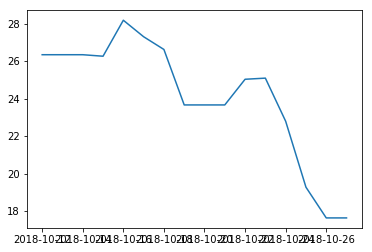

In [834]:
#plt.plot(get_avg_ypred(y_pred))
plt.plot(amd_stock[284:])

In [846]:
test_index = amd_stock[284:].index

In [850]:
predicted_stock = pd.Series(get_avg_ypred(y_pred))

In [851]:
predicted_stock.index=test_index

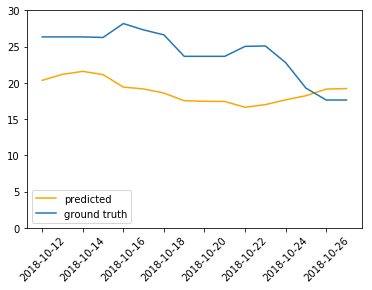

In [892]:
plt.figure()
axes = plt.gca()
axes.set_ylim([0,30])
plt.xticks(rotation=45)

plt.plot(predicted_stock, label= 'predicted', color = 'orange')
plt.plot(amd_stock[284:], label='ground truth')
plt.legend(loc='best')
plt.show()

In [860]:
from scipy.stats import pearsonr

pearsonr(amd_stock[284:], predicted_stock)

(0.2640976840832782, 0.3229590585745307)

## 4.3 ARIMA

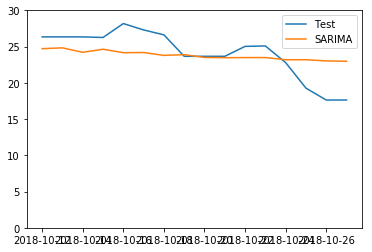

In [914]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_hat_avg = amd_stock[284:]
fit1 = SARIMAX(amd_stock[92:284], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2018-10-12", end="2018-10-27", dynamic=True)
plt.figure()
#plt.plot( amd_stock[:284], label='train')
axes = plt.gca()
axes.set_ylim([0,30])
plt.plot(amd_stock[284:], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()


In [916]:
pearsonr(amd_stock[284:], y_hat_avg['SARIMA'])

(0.7835243149808842, 0.000329678900440087)

## 4.4 compare

<Figure size 600x400 with 0 Axes>

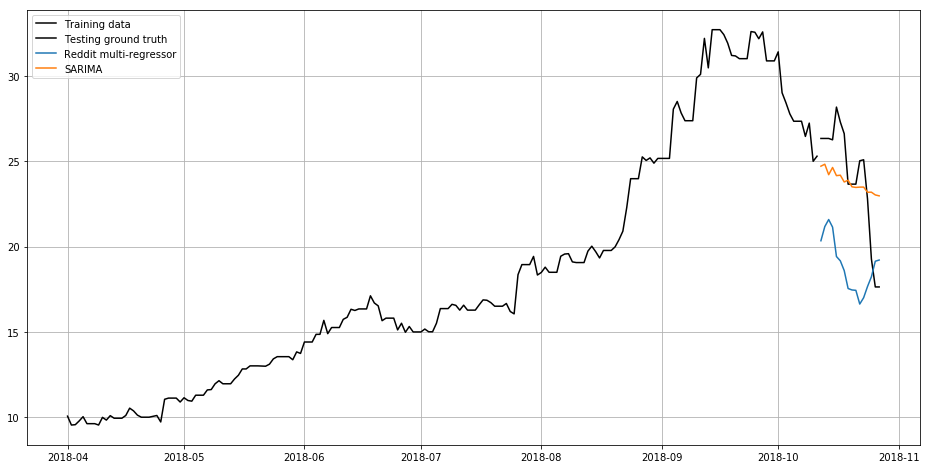

In [915]:
plt.figure()
#axes = plt.gca()
#axes.set_ylim([0,35])
plt.figure(figsize=(16,8))
plt.plot( amd_stock[90:284], label='Training data', color='black')
plt.plot(amd_stock[284:], label='Testing ground truth', color='black')
plt.plot(predicted_stock , label='Reddit multi-regressor')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.grid()
plt.show()

In [922]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print sqrt(mean_squared_error(amd_stock[284:], y_hat_avg.SARIMA))
print sqrt(mean_squared_error(amd_stock[284:], predicted_stock))


2.78663839615
6.13545591416


<a id='section_5'></a>

# 5. conclusion

- pearson correlation:
    - Reddit multi-regressor predictions showed lower correlation coefficient
    
- RMSE 
    - Reddit multi-regressor showed higher error
    

- possible reasons:
    - Reddit multi-regressor tries to predict stock price well ahead of time 
    - ARIMA used more data than Reddit Muti-Regressor - ARIMA failed to converge when same training set was fed into it, so more training data was used to train that model
    - Reddit input data sparse
    - different rolling window
    - more training data 
    
- future improvements:
    - use different type of model
    - use a better sentiment analyzer 
    - Reddit text relevance
    - Reddit text clean up - profanity isn't always negative sentiment
    - add more features: comments polarity, total score
    